# Assignment 2: System identification
## Y2 Computing (2021/22), weeks 5&ndash;7

In this assignment you are presented with a number of "black box" components, each of which contains code that models a certain electronic system. By investigating the response of each box to generated input (voltage) signals, you will be able to determine the type of system each box contain and estimate its parameters (e.g. resistance and inductance).
Before you continue with this assignment, please read `Y2_Computing_System_Identification.pdf` available on Canvas, and work though the example notebook `black_box_example.ipynb` provided as part of this assignment.

Please **enter your student ID** in the variable studentID and execute the cell below before starting the assignment. This will import the necessary Boxes objects. As in assignment 1, the final cell contains a function call (`Boxes.check()`) which you should run to check that the naming of variables and functions in each task is correct.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15

# Do not alter any of the code within this cell other than the value of studentID
from module_engine.assignment import Boxes
studentID = 0

# Creating box objects to be investigated in this assignment
t1_box1, t1_box2, t1_box3, t2_box, t3_box = Boxes.get_boxes(studentID)

*** Using a temporary ID. Switch to your own ID as soon as possible. ***

*** Using a temporary ID. Switch to your own ID as soon as possible. ***

*** Using a temporary ID. Switch to your own ID as soon as possible. ***

*** Using a temporary ID. Switch to your own ID as soon as possible. ***

*** Using a temporary ID. Switch to your own ID as soon as possible. ***



## Task 1
#### Marks available:  4

Each of the following circuits is contained in *one* of the boxes `t1_box1`, `t1_box2` and `t1_box3`:
- RL high pass filter;
- RC low pass filter;
- RLC band pass filter.

By analysing the action of each box on custom signals and employing the `.fft` and `.fftfreq` functions from `numpy.fft`, identify the type of circuit contained in each box. A blank cell has been provided for your working, but you are free to insert as many additional cells as you require. 

After completing your investigation set the variables `RL_circuit`, `RC_circuit` and `RLC_circuit` in the next cell to a value of 1, 2 or 3 to indicate which box matches the relevant circuit. For example, write `RC_circuit = 1` if you believe `t1_box1` to be the RC low pass filter or
`RC_circuit = 2` if you believe that system is in `t1_box2`.

**Reminder**:
Use the `.process()` method to interact with the `Boxes` objects, as shown in `black_box_example.ipynb`

**Hint**:
In order to obtain an informative result, your time domain input signal should contain frequency components ranging from 10 to 4000 Hz.

In [2]:
# Useful functions
# ================

def swept_sine(f1, f2, t):
    """
    Create a sine wave with a frequency sweeping between f1 and f2.

    Parameters
    ----------
    f1 : float
        Initial frequency in Hz.
        
    f2 : float
        Final frequency in Hz.
        
    t : array
        Time array (units of seconds), should be uniformly spaced.

    Returns
    -------
    output : array
        The increasing frequency sine wave array.
    """
    f = np.linspace(f1, f2, t.size)
    output = np.sin(2*np.pi*f*t)
    
    return output

def get_time_array(N, duration):
    """
    Generate a time array with a given number of samples, and a given 
    duration. Also prints some useful summary information.

    Parameters
    ----------
    N : int
        The number of samples in the time array.
        
    duration : float
        The duration of the time array in seconds.

    Returns
    -------
    t : array
        The generated time array.
    """
    t = np.linspace(0, duration, num=N, endpoint=False) 
    timestep = np.diff(t)[0]
    print(f'Data points = {N}')
    print(f'Time step   = {timestep} s')
    print(f'Sampling frequency = {1/timestep} Hz')
    
    return t

def get_frequency_array(t):
    """
    Generate a frequency array from a given time array. If the sample spacing 
    is in seconds, then the frequency unit is Hz.

    Parameters
    ----------
    t : array
        The input time array.

    Returns
    -------
    f : array
        The generated frequency array. Note that this contains negative 
        frequencies.
    """
    N = len(t)
    timestep = np.diff(t)[0]
    f = np.fft.fftfreq(N, d=timestep)
    
    return f

def get_positive_frequencies(A):
    """
    By default, the numpy.fft functions consider negative frequencies 
    (relevant if our input signal is complex). This function extracts the 
    positive frequency components of a given array. See the implementation 
    details at https://numpy.org/doc/stable/reference/routines.fft.html for
    more information.

    Parameters
    ----------
    A : array
        This can be an array of frequencies as returned by 
        get_frequency_array(), or a frequency-domain signal as returned by 
        numpy.fft.fft().

    Returns
    -------
    array
        The components of the input array, A, which correspond to the positive 
        frequencies.
    """
    N=len(A)
    
    if len(A)//2==0:
        N2=int(N/2)
    else:
        N2=int((N+1)/2)
        
    return A[1:N2]


In [3]:
# Generate input signal, s_in
# ===========================

# We need to ensure our time array can hold frequency content between 10 and
# 4000 Hz. 

# The lowest possible frequency in a time array is given by 1/duration, so we
# need a duration of at least 0.1 s. 

# The largest possible frequency in a time array is given by half the sampling 
# frequency, or N/(2*duration). So, we require N > 2*duration*4000.

# Generate time array
t = get_time_array(N=10000, duration=1.0)

# Generate input signal
s_in = swept_sine(10, 4000, t)

Data points = 10000
Time step   = 0.0001 s
Sampling frequency = 10000.0 Hz


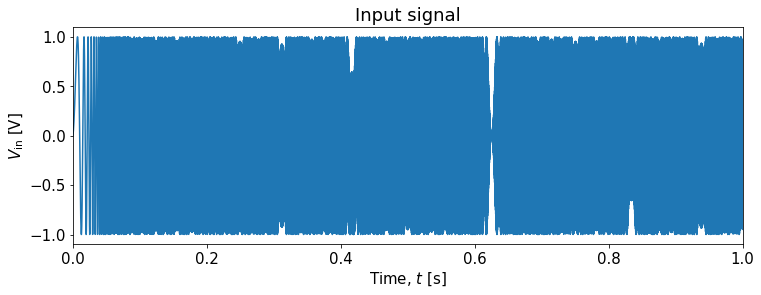

In [4]:
# Plot the input signal
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(t, s_in)

ax.set_title('Input signal') 
ax.set_xlabel(r'Time, $t$ [s]') 
ax.set_ylabel(r'$V_{\mathrm{in}}$ [V]')

_ = ax.set_xlim(0,1)

In [5]:
# Investigate
# ===========

def investigate(box_process, t, s_in, plot=True):    
    """
    Pass an input signal through a box, with an option to plot the 
    frequency-domain signal amplitudes and transfer function. Returns the 
    frequency-domain input and output signals.

    Parameters
    ----------
    box_process : function
        A 'black box' process, which accepts a time array and an input signal, 
        and returns an output signal
        
    t : array
        Time array (units of seconds), should be uniformly spaced.
        
    s_in : array
        The (time domain) input signal.
        
    plot : bool, optional
        If True, plot the frequency-domain signal amplitudes and transfer 
        function. The default is True.
        
    Returns
    -------
    f : array
        The (positive) frequencies at which the frequency-domain input and 
        output signals are evauluated (units of Hz).
        
    S_in : array
        The frequency-domain input signal.
        
    S_out : array
        The frequency-domain output signal.
    """
    # Pass input signal through the box and create an output signal
    s_out = box_process(t, s_in)

    # Perform the Fourier transforms
    S_in_all = np.fft.fft(s_in)
    S_in = get_positive_frequencies(S_in_all)
    
    S_out_all = np.fft.fft(s_out)
    S_out = get_positive_frequencies(S_out_all)
    
    # Generate frequency array
    f_all = get_frequency_array(t)
    f = get_positive_frequencies(f_all)

    if plot:
        
        fig, axs = plt.subplots(2, 1, figsize=(12,8), sharex=True)
    
        # Plot the absolute values of transformed_output 
        axs[0].plot(f, np.abs(S_in), 'C0', label='Input signal') 
        axs[0].plot(f, np.abs(S_out), 'C1', label='Output signal')
        axs[0].set_title('FFT of input and output signals')
        axs[0].set_ylabel('|Amplitude| [V/Hz]')
        axs[0].legend()
    
        axs[1].plot(f, np.abs(S_out/S_in), 'k:')
        axs[1].set_xlabel('Frequency, $f$ [Hz]')
        axs[1].set_ylabel('Transfer function, |T| [V/V]')
    
        axs[1].set_xscale('log')
    
        fig.subplots_adjust(hspace=0)
    
    return f, S_in, S_out

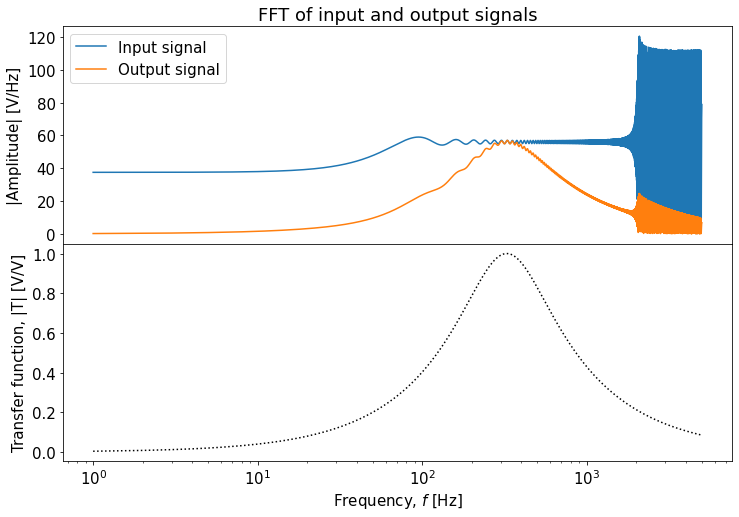

In [6]:
_ = investigate(t1_box1.process, t, s_in)

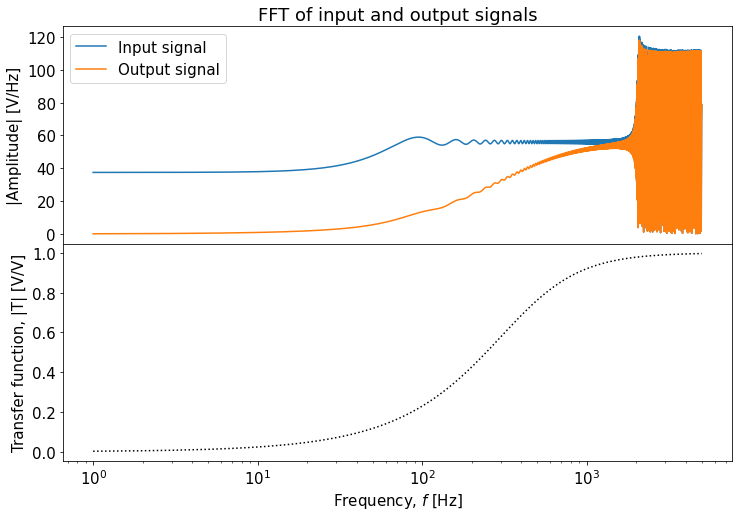

In [7]:
_ = investigate(t1_box2.process, t, s_in)

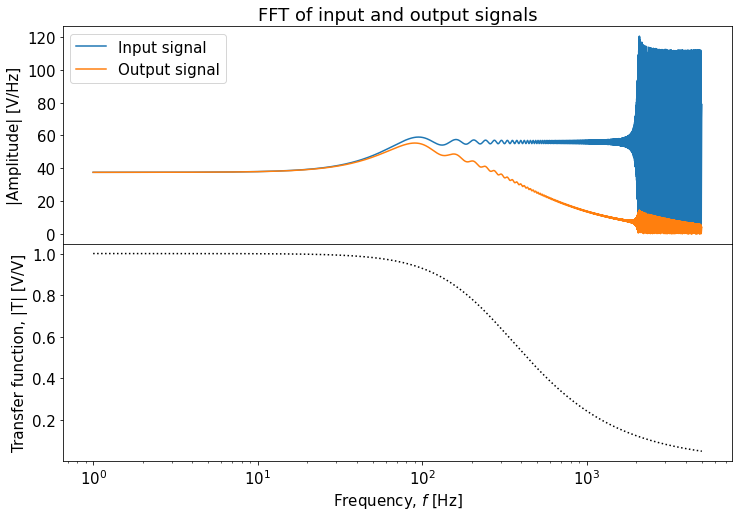

In [8]:
_ = investigate(t1_box3.process, t, s_in)

In [9]:
# Now assign each of these variables a (unique) value of 1, 2 or 3.
# For example if you know that t1_box2 contains the RC_circuit, set RC_circuit=2.
# If instead you found the RC_circuit in t1_box1, set RC_circuit=1.
RL_circuit = 2
RC_circuit = 3
RLC_circuit = 1

## Task 2
#### Marks available:  3
You are to work with the black box `t2_box` (defined in the first cell of the notebook) in this task. It is known that this box contains an **RL high pass** filter circuit, but with parameter values **different** from those of the RL high pass circuit in task 1. 

Employing a similar method to that used in task 1, examine the characteristic transfer function of this circuit to determine an approximate value for the associated corner frequency, i.e. such frequency $f_0$ that $|T(f_0)| =1/\sqrt{2}$. 

The examples in `Y2_Computing_System_Identification.pdf` refer to $T(\omega)$ while we sometimes use $T(f)$. These are the same function just plotted over a different axis ($\omega = 2\pi f$). It is easy to make mistakes when applying this scaling. You should always check if you are using the right frequency scaling for a given task.

After you complete you investigation store the value for $f_0$ in the variable `corner_frequency`. During marking, your value will be compared to the true value with a tolerance of 10 Hz. Ensure that your sample density in the frequency domain is sufficient to achieve this level of accuracy.

Furthermore, assuming that the resistance of the circuit is R=200 &Omega;, calculate the inductance of the inductor in Henrys and store this in the variable `inductance`. Do **not** round this value.

**Hints**:
  * Your time domain input signal should contain frequency components ranging from 10 to 3000 Hz in order to obtain an informative result. 
  * For finding a specific value in a numpy array you may use the `numpy.argmin` function. 
  Play with and understand the following code:
  ```
  a=np.array([10, 11, 12, 15, 20, 30])
  index=np.argmin(np.abs(a-15))
  print(index)
  print(a[index])
  ```
  * To check visually whether you found the corner frequency correctly you can plot additional lines into the graph with the transfer fucntion, for example using `plt.axvline(x=f0)` and `plt.axhline(y=1/np.sqrt(2),linestyle='--')`.

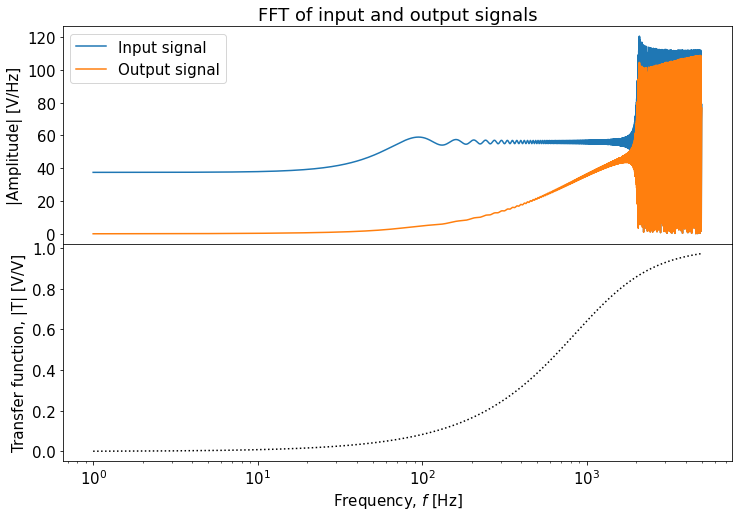

In [10]:
f, S_in, S_out = investigate(t2_box.process, t, s_in)

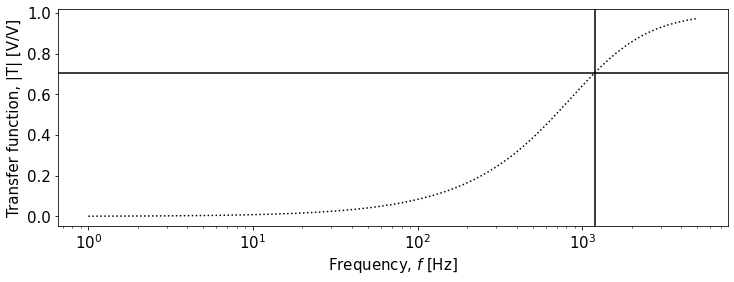

In [11]:
# Identify the frequency at which the modulus of the transfer function = 1/sqrt(2)

# Transfer function
T = S_out/S_in

# Corner frequency
f0 = f[np.argmin(np.abs(np.abs(T)-(1/np.sqrt(2))))]

# Re-plot to check
fig, ax = plt.subplots(1, 1, figsize=(12,4))

ax.plot(f, np.abs(T), 'k:')
ax.axvline(f0, c='k')
ax.axhline(1/np.sqrt(2), c='k')

ax.set_xlabel('Frequency, $f$ [Hz]')
ax.set_ylabel('Transfer function, |T| [V/V]')

ax.set_xscale('log')

In [12]:
# The inductance, L, is related to the (angular) frequency by omega0 = R/L. 
# Given a resistance of 200 ohms, we have
L = 200/(2*np.pi*f0)

In [13]:
# Put your solutions to task 2 here
corner_frequency = f0 # Corner frequency in Hz
inductance = L        # Inductance in Henrys

## Resonance in RLC series circuits
The sharp peak in transmission for an RLC series circuit associated with a minimum of impedance is referred to as series resonance, with the **resonance frequency** $f_0$ being that at which the transfer function attains its maximum value of $T(\omega_0)=1$. Considering that

$$|T(\omega) | = \frac{R}{\sqrt{R^2+(\omega L - 1/\omega C)^2}},$$

this occurs when $\omega L = 1/\omega C$ (i.e. the inductive reactance equals the capacitive reactance). Therefore the resonance frequency is

$$\omega_0^2 = \frac{1}{LC} \implies f_0 = \frac{1}{2\pi \sqrt{LC}}.$$

For all intents and purposes, a signal is passed by an RLC circuit if it has a frequency contained between the **two** (lower and upper) cut-off frequencies, $f_l$ and $f_h$, at which the transfer function has a magnitude of $1/\sqrt{2}$. The **bandwidth** of the circuit (also known as the resonance width) is then defined as the difference between these two frequencies, i.e $f_h - f_l$.

## Task 3
#### Marks available:  8
You are to work with the blackbox `t3_box` (defined in the first cell of the notebook) in this task. This contains an **RLC band pass** filter circuit, with values of resistance, inductance and capacitance different from those of the RLC circuit in task 1.

Firstly, determine the transfer function for this circuit and **plot its magnitude**, $|T(f)|$, against frequency, $f$ (in Hz), on the interval <nobr>$f \in [10,2000]$ Hz</nobr> on the figure object provided (`student_figure`). You should ensure that your input signal contains frequency components ranging from 10 to <nobr>2000 Hz</nobr> (we recommend that you use at least 4000 samples and a signal length of 1s).

You should use a linear scale on the y-axis (do **not** use dB), and a logarithmic scale on the frequency axis. This is achieved through the use of the `plt.semilogx()` function. Your plot should also have a title and axis titles. 

Do not add other data or lines to the plot in `student_figure`. If you want to make additional plots, you should create those as separate figures that use different names.

Using your plotted data or otherwise, estimate the **resonant frequency** and the **bandwidth** of the circuit in Hz and assign these to the variables `resonant_frequency` and `bandwidth`. As in task 2, these values should be accurate to 10 Hz.

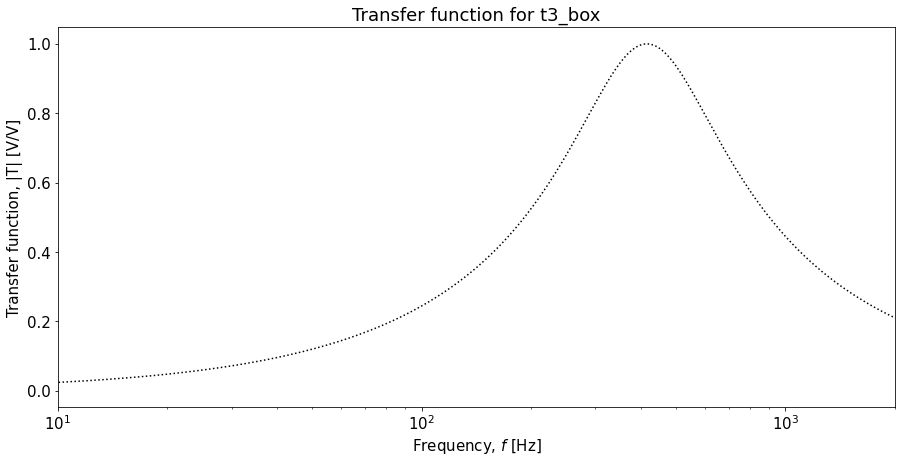

In [14]:
# Pass a signal to the box
f, S_in, S_out = investigate(t3_box.process, t, s_in, plot=False)

# Transfer function
T = S_out/S_in

# Plot transfer function
student_figure = plt.figure(figsize=(15,7))

plt.semilogx(f, np.abs(T), 'k:')

plt.title('Transfer function for t3_box')
plt.xlabel('Frequency, $f$ [Hz]')
plt.ylabel('Transfer function, |T| [V/V]')

plt.xlim(10,2000)

plt.show()

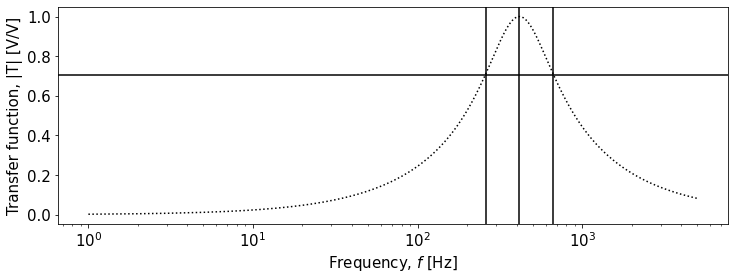

In [15]:
# Identify resonant frequency
f0_index = np.argmax(np.abs(T))
f0 = f[f0_index]

# To calculate the bandwidth, we first find the upper and lower cut-off 
# frequencies. Split the transfer function at the resonant frequency, and then 
# apply the same method as in task 2.

f_lower = f[:f0_index]
T_lower = T[:f0_index]

f_upper = f[f0_index:]
T_upper = T[f0_index:]

fl = f_lower[np.argmin(np.abs(np.abs(T_lower)-(1/np.sqrt(2))))]
fh = f_upper[np.argmin(np.abs(np.abs(T_upper)-(1/np.sqrt(2))))]

# Re-plot to check
fig, ax = plt.subplots(1, 1, figsize=(12,4))

ax.plot(f, np.abs(T), 'k:')
ax.axvline(f0, c='k')
ax.axvline(fl, c='k')
ax.axvline(fh, c='k')
ax.axhline(1/np.sqrt(2), c='k')

ax.set_xlabel('Frequency, $f$ [Hz]')
ax.set_ylabel('Transfer function, |T| [V/V]')

ax.set_xscale('log')

In [16]:
resonant_frequency = f0 # Resonant frequency in Hz
bandwidth = fh-fl       # Bandwidth in Hz

## Task 4
#### Marks available:  5
For the final task you are to create your own black box function called `my_box_process(t, s_in, R, L)` that mimics the behaviour of an **RL low pass filter** circuit of resistance `R` (Ohms) and inductance `L` (Henrys).

`t` and `s_in` will be two NumPy arrays representing an input voltage signal with physical amplitude `s_in[i]` at time `t[i]`, and the function should return a NumPy array containing the **real** output signal in the time domain (i.e. the final output data must be real numbers not complex numbers).

You will need the transfer function for the RL low-pass filter circuit:
$$T(f) = \frac{1}{1+i(f/f_0)},$$ where $f_0 = R/(2\pi L)$.

#### Hints:
- Use `.fft` to perform an FFT on the input signal before applying the transfer function in the frequency domain. You will then need to use the `.ifft` function to represent this modulated signal in the time domain (see [ifft in the numpy documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.ifft.html)).
- You may wish to define the transfer function separately and call this within my_box_process.
- In Python, `1j` is used to represent the imaginary unit.
- Make sure your function returns a physical time domain signal (i.e. real values that can change sign). The `ifft` function will return an array of complex numbers with the real part of these numbers containing the signal we are interested in.
- Because the input and output of your black box must be NumPy arrays, you do not need to use any `for` loops in your code.

In [17]:
# Function definition for task 4

def my_box_process(t, s_in, R=100, L=0.02):
    
    # Generate frequency array
    f = get_frequency_array(t)
    
    # Calculate cut-off frequency
    f0 = R/(2*np.pi*L)
    
    # Take input signal to the frequency domain
    S_in = np.fft.fft(s_in)
    
    # Create the transfer function
    T = 1/(1+1j*(f/f0))
    
    # Apply transfer function
    S_out = S_in*T
    
    # Convert back to the time domain (we are only interested in the real part)
    s_out = np.real(np.fft.ifft(S_out))
    
    return s_out

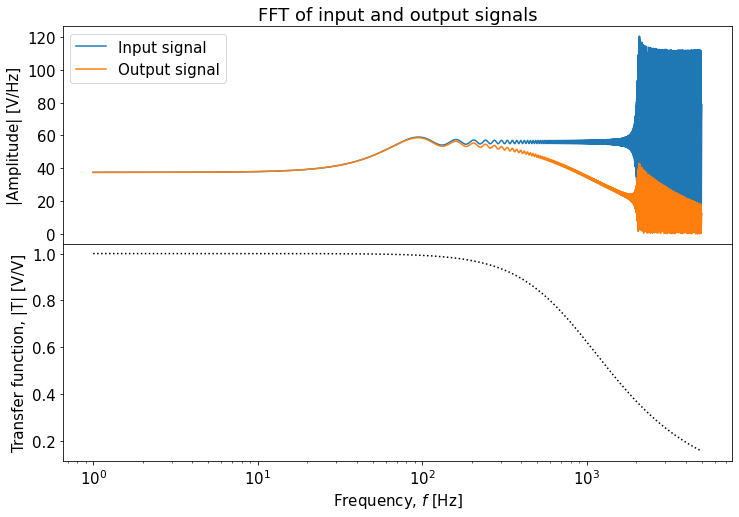

In [18]:
_ = investigate(my_box_process, t, s_in)

Please execute the following statement before submitting your work. It will check that you have used correct naming for the variables and functions specified in the above tasks. It will not tell you whether you have correctly defined and implemented these! You may execute this statement as many times as required.

In [19]:
Boxes.check()

my_box_process function is correctly named.
RL_circuit variable is correctly named.
RC_circuit variable is correctly named.
RLC_circuit variable is correctly named.
corner_frequency variable is correctly named.
inductance variable is correctly named.
resonant_frequency variable is correctly named.
bandwidth variable is correctly named.
RL_circuit, RC_circuit and RLC_circuit are assigned in a valid way.


Before you submit, select 'Kernel &rarr; Restart & Run All' in the Jupyter menu. This will reset the notebook and run all your code sequentially, similar to what marking script will do.

# For demonstrators
This example comes with the marking script included. Thus you can check your marks by exectuting the following cell. The students will not get the `marker` code and will *not* be able to do this.

In [20]:
import module_engine.marker as mark
mk=mark.Solution2(studentID)
mk.mark();

Task 1:
 We checked that 'RLC_circuit', 'RL_circuit' and 'RC_circuit' were variables in your notebook: RLC_circuit was found, RL_circuit was found, RC_circuit was found. You correctly identified box 1 with RLC_circuit, you correctly identified box 2 with RL_circuit, you correctly identified box 3 with RC_circuit. 
Score: 4/4 

Task 2:
 'corner_frequency' was found and its value was within 10Hz of the true value (1197.5). 'inductance' was found and its value was correct (error carried forward considered).
Score: 3/3 

Task 3:
 A figure called 'student_figure' was found.  The figure has an x axis label, y axis label and a title .  The x axis is logarithmic spaced, as required (log10).  The range of frequencies you explored were good (at least from 200.0 to 1800.0).  Your plotted values matched the output of the true transfer function to within an acceptable tolerance. 'resonant_frequency' was found and its value was within 10Hz of the true value (416.0). 'bandwidth' was found and its val

Marking student ID 0
*** Using a temporary ID. Switch to your own ID as soon as possible. ***

0.0
